<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
#Mount google drive to access data

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
from PIL import Image
import glob
train_path = []
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof/*.png'):
    im=Image.open(filename)
    train_path.append(im)
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/*.png'):
    im=Image.open(filename)
    train_path.append(im)
from PIL import Image
import glob
valid_path = []
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/*.png'):
    im=Image.open(filename)
    valid_path.append(im)
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/*.png'):
    im=Image.open(filename)
    valid_path.append(im)

In [ ]:
# add preprocessing layer to the front of ResNet
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - resnet has existing weights
for layer in resnet.layers:
  layer.trainable = False
  
 
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
folders = 1

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# our layers
x = Flatten()(resnet.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(folders, activation='sigmoid')(x)


In [ ]:

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)
# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 5,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/',
                                            target_size = (224, 224),
                                            batch_size = 5,
                                            class_mode = 'binary')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


'r=model.fit_generator(training_set,\n                         samples_per_epoch = 8000,\n                         nb_epoch = 5,\n                         validation_data = test_set,\n                         nb_val_samples = 2000)'

In [ ]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=15, #len(training_set),
  validation_steps=20 #len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
15/15 [==============================] - 34s 298ms/step - loss: 20.3967 - accuracy: 0.4000 - val_loss: 2.0397 - val_accuracy: 0.4800
Epoch 2/5
15/15 [==============================] - 3s 222ms/step - loss: 2.2438 - accuracy: 0.4667 - val_loss: 1.3737 - val_accuracy: 0.5300
Epoch 3/5
15/15 [==============================] - 3s 220ms/step - loss: 1.4258 - accuracy: 0.4000 - val_loss: 1.4231 - val_accuracy: 0.4700
Epoch 4/5
15/15 [==============================] - 3s 220ms/step - loss: 1.4933 - accuracy: 0.4800 - val_loss: 0.6492 - val_accuracy: 0.6000
Epoch 5/5
15/15 [==============================] - 3s 221ms/step - loss: 1.3734 - accuracy: 0.5067 - val_loss: 1.0734 - val_accuracy: 0.5600


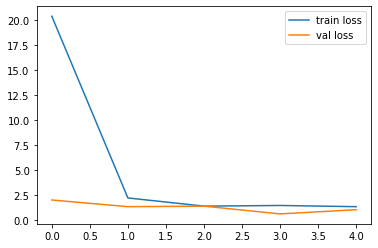

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')




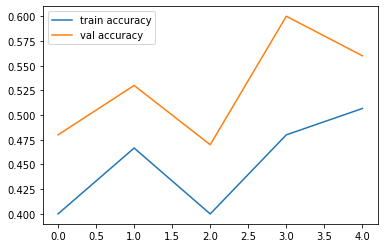

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_model.h5')